In [1]:
import networkx as nx
import numpy as np
import math
from ipywidgets import widgets
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Parameters

# dataset = 'infectious'
# beta = 1
# Delta_T = 0.1 # Fraction of dataset to select (this is then divided by phi)
# k = 10
# phi = 0.1
# lines = 0
# runs = 3

def get_data(dataset, Delta_T, phi):
    lines = 0
    if dataset == "infectious":
        lines = 17298
    elif dataset == "ht09_contact":
        lines = 20818
    elif dataset == "SFHH":
        lines = 70261
    elif dataset == "tij":
        lines = 78249

    total_edges = int(lines * Delta_T)
    random_start_point = np.random.uniform(0, float(1 - Delta_T))
    start = int(lines * random_start_point)

    train_lines = int(total_edges * float(1 - phi))
    mid = start + train_lines
    end = start + total_edges

    print(f'Total lines: {total_edges}, train lines {train_lines}')
    print(f'Starting at {start} till {mid} to predict till {end}')

    path_to_file = f'../data/{dataset}.txt'

    all_data = np.loadtxt(path_to_file, delimiter='\t', dtype=int)[start: end]
    train_data = all_data[:train_lines]
    predict_data = all_data[train_lines:]
    new_points = predict_data[-1][2] - predict_data[0][2] + 1
    print(f'Starting at {train_data[0]} till {predict_data[0]} to predict till {predict_data[-1]}')


    return all_data, train_data, predict_data, train_lines, total_edges, start, mid, end, new_points

# Check all edges are unique

# a = np.array([src, dst, ts])
# a = a.T
# # np.any(np.all(np.unique(a, axis=1) == a, axis=1))
# u, c = np.unique(a, return_counts=True, axis=0)
# u[c > 1]

In [3]:
# Construct Graph
def make_graph(all_data):
    src, dst, ts = [], [], []
    graph = nx.MultiGraph()

    for line in all_data:
        src.append(line[0])
        dst.append(line[1])
        ts.append(line[2])

        if graph.nodes.get(line[0]) is None:
            graph.add_node(line[0], is_infected=False, infected_at=math.inf, influence=-1, influences=None, pred=None, polyfit_prediction=None)
        if graph.nodes.get(line[1]) is None:
            graph.add_node(line[1], is_infected=False, infected_at=math.inf, influence=-1, influences=None, pred=None, polyfit_prediction=None)

        graph.add_edge(line[0], line[1], key=line[2], timestamp=line[2])

    src, dst, ts = np.array(src), np.array(dst), np.array(ts) # ts is given sorted

    return src, dst, ts, graph

In [4]:
def fill_holes_timestamps(start, mid, end, influences):
    xs, ys = [], []
    for i in range(start, end + 1):
        if i < mid:
            xs.append((i, influences.get(str(i), 0)))
        else:
            ys.append((i, influences.get(str(i), 0)))
            
    return xs, ys

In [5]:
def check_edge(edge, g, inf, ins, beta):
    if g.nodes.get(edge[0])['is_infected'] and edge[2] > g.nodes.get(edge[0])['infected_at'] and not g.nodes.get(edge[1])['is_infected'] and np.random.random() <= beta:
        inf += 1
        g.nodes.get(edge[1])['in_infected'] = True
        g.nodes.get(edge[1])['infected_at'] = edge[2]
        ins[str(edge[2])] = ins.get(str(edge[2]), 0) + 1
    
    return inf, ins, g

def find_influence_of_node(edges, node, at, beta):
    g = nx.Graph()
    influence, influences, pred = 0, {}, {}
    
    for edge in edges:
        if g.nodes.get(edge[0]) is None:
            g.add_node(edge[0], is_infected=False, infected_at=math.inf)
        if g.nodes.get(edge[1]) is None:
            g.add_node(edge[1], is_infected=False, infected_at=math.inf)

    g.nodes.get(node)['is_infected'] = True
    g.nodes.get(node)['infected_at'] = at

    # TODO: Check influence. I think it's getting unset somewhere because of how Python handles pointers.
    for i, edge in enumerate(edges):
        influence, influences, g = check_edge(edge, g, influence, influences, beta)
        new_edge = (edge[1], edge[0], edge[2])
        influence, influences, g = check_edge(new_edge, g, influence, influences, beta)
        
    return influence, influences

# TODO: Fix this
def find_influence_in_graph(graph, all_data, beta):
    for i, edge in enumerate(all_data):
        for e in [edge[0], edge[1]]:
            if graph.nodes.get(e)['influence'] == -1:
                z, zz = find_influence_of_node(all_data, e, edge[2], beta)
                graph.nodes.get(e)['influence'] = z
                graph.nodes.get(e)['influences'] = zz

    most_influential_nodes = sorted(list(graph.nodes.data("influence")), key=lambda x: x[1], reverse=True)[:3]
    print(f"most influentual nodes: {most_influential_nodes}")
    return most_influential_nodes

In [6]:
def polyfit(data, new_points, dimension):
    #print(f"new_points: {new_points}")
    data = np.array(list(map(lambda x: [x[0], x[1]], data)))
    fit = np.polyfit(data[:, 0], data[:, 1], 1) # The use of 1 signifies a linear fit.

    line = np.poly1d(fit)
    new_points = np.arange(new_points) + (data[-1][0] + 1)
    return np.cumsum(line(new_points))

In [7]:
def plot_1(most_influential_nodes, graph):
    clr = ['r', 'g', 'b', 'y', 'm']

    for i, node in enumerate(most_influential_nodes):
        y_true = graph.nodes.get(node[0])['pred']
        y_pred = graph.nodes.get(node[0])['polyfit_prediction']
        ts = list(map(lambda x: x[0], y_true))
        plt.plot(ts, np.cumsum(list(map(lambda x: x[1], y_true))), 'o', color=clr[i], markersize=2, label=f"True Node: {i}")
        plt.plot(ts, y_pred, '--', color=clr[i], label=f"Predicted Node {i}")

    # save the plot
    plot_name = 's.png'
    plt.xlabel('Timestamps')
    plt.ylabel('Influence')
    plt.legend(loc="upper left")    
    plt.savefig(plot_name)
    plt.show()

def plot_2(most_influential_nodes, graph):
    clr = ['r', 'g', 'b', 'y', 'm']
    predicted_data = []
    true_data = []
    ts = []
    for i, node in enumerate(most_influential_nodes):
        ts.append(list(map(lambda x: x[0], graph.nodes.get(node[0])['pred'])))
        true_data.append(np.cumsum(list(map(lambda x: x[1], graph.nodes.get(node[0])['pred']))))
        predicted_data.append(graph.nodes.get(node[0])['polyfit_prediction'])

    # Set the seaborn style
    sns.set(style='whitegrid')

    # Set up the figure and subplots
    fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 20))
    fig.tight_layout(pad=6.0)

    # Set a custom color palette
    palette = sns.color_palette("husl", 2)

    for i, (predicted, true) in enumerate(zip(predicted_data, true_data)):
        sns.lineplot(x=ts[i], y=predicted, label='Predicted', linewidth=2, linestyle='-', marker='o', markersize=8, color=palette[0], ax=axes[i])
        sns.lineplot(x=ts[i], y=true, label='True', linewidth=2, linestyle='-', marker='x', markersize=8, color=palette[1], ax=axes[i])

        axes[i].set_title(f'Most influencing node #{i+1}', fontsize=16, fontweight='bold', pad=15)
        axes[i].legend(fontsize=12, loc='upper right')
        axes[i].set_xlabel('Timestamps', fontsize=14)
        axes[i].set_ylabel('Influence', fontsize=14)
        axes[i].tick_params(axis='both', which='major', labelsize=12)

    # Remove the top and right spines for a cleaner look
    sns.despine()

    plt.show()

In [8]:
def simulate(dataset, delta_t, phi, beta, geterror=False):
    print(f'Running simulation for dataset {dataset} with delta_t {delta_t} and phi {phi} and beta {beta}')
    flag = True

    while flag:
        flag = False 
        all_data, train_data, predict_data, train_lines, total_edges, start, mid, end, new_points = get_data(dataset, delta_t, phi)
        src, dst, ts, graph = make_graph(all_data)
        most_influential_nodes = find_influence_in_graph(graph, all_data, beta) # 5 most influential nodes [(node id, influence)]
        
        for node in most_influential_nodes:
            thisnode = graph.nodes.get(node[0])
            if thisnode is not {}:
                thisnode['influences'], thisnode['pred'] = fill_holes_timestamps(train_data[0][2], \
                                                                                 predict_data[0][2], \
                                                                                 predict_data[-1][2], \
                                                                                 thisnode['influences'])
                if len(thisnode['pred']) > 3:
                    thisnode['polyfit_prediction'] = polyfit(thisnode['influences'], new_points=new_points, dimension=1)

        
        for node in most_influential_nodes:
            if not bool(graph.nodes.get(node[0])['pred']):
                flag = True

    if geterror:
        return np.average((np.array(thisnode['pred'])[:, 0] - thisnode['polyfit_prediction']) ** 2)
    
    plot_1(most_influential_nodes, graph)
    plot_2(most_influential_nodes, graph)

In [9]:
dataset_dropdown = widgets.Dropdown(options=['infectious', 'ht09_contact', 'SFHH', 'tij_InVS15'], description='Dataset', disabled=False, continuous_update=True)
phi_slider = widgets.FloatSlider(min=0.1, max=1, step=0.1, value=0.1, continuous_update=True)
delta_t_slider = widgets.FloatSlider(min=0.1, max=1, step=0.1, value=0.1, continuous_update=True)
beta_slider = widgets.FloatSlider(min=0.1, max=1, step=0.1, value=0.75, continuous_update=True)

w = widgets.interactive(simulate, dataset=dataset_dropdown.value, delta_t=delta_t_slider, phi=phi_slider, beta=beta_slider)
display(w)

interactive(children=(Text(value='infectious', description='dataset'), FloatSlider(value=0.1, description='del…

In [17]:
def explore_betas(dataset, delta_t, phi):
    betas = []
    for beta in range(1, 21):
        beta = beta * 0.05
        betas.append((beta, simulate(dataset=dataset, delta_t=delta_t, phi=phi, beta=beta, geterror=True)))
    return np.array(betas)

explore_betas(dataset=dataset_dropdown.value, delta_t=delta_t_slider.value, phi=phi_slider.value)

Running simulation for dataset infectious with delta_t 0.1 and phi 0.1 and beta 0.05
Total lines: 1729, train lines 1556
Starting at 8632 till 10188 to predict till 10361
Starting at [214 218 569] till [235 241 649] to predict till [249 252 657]
most influentual nodes: [(233, 10), (196, 10), (197, 8)]
Running simulation for dataset infectious with delta_t 0.1 and phi 0.1 and beta 0.1
Total lines: 1729, train lines 1556
Starting at 2341 till 3897 to predict till 4070
Starting at [ 33  36 242] till [114 115 337] to predict till [122 134 347]
most influentual nodes: [(71, 17), (70, 14), (87, 11)]
Running simulation for dataset infectious with delta_t 0.1 and phi 0.1 and beta 0.15000000000000002
Total lines: 1729, train lines 1556
Starting at 11375 till 12931 to predict till 13104
Starting at [297 300 742] till [261 263 822] to predict till [261 263 834]
most influentual nodes: [(290, 22), (296, 21), (287, 21)]
Running simulation for dataset infectious with delta_t 0.1 and phi 0.1 and beta

array([[5.00000000e-02, 4.25350661e+05],
       [1.00000000e-01, 1.16829365e+05],
       [1.50000000e-01, 6.81560708e+05],
       [2.00000000e-01, 1.13226386e+06],
       [2.50000000e-01, 6.19184738e+04],
       [3.00000000e-01, 2.67332819e+05],
       [3.50000000e-01, 9.48499335e+04],
       [4.00000000e-01, 1.21274418e+06],
       [4.50000000e-01, 2.82899183e+05],
       [5.00000000e-01, 2.77218101e+05],
       [5.50000000e-01, 2.17181384e+05],
       [6.00000000e-01, 6.42540479e+05],
       [6.50000000e-01, 9.26042982e+04],
       [7.00000000e-01, 9.41185887e+05],
       [7.50000000e-01, 1.04128442e+05],
       [8.00000000e-01, 2.14094220e+05],
       [8.50000000e-01, 5.00740957e+05],
       [9.00000000e-01, 1.51077169e+05],
       [9.50000000e-01, 1.18963303e+05],
       [1.00000000e+00, 4.90029820e+05]])

In [18]:
def explore_phis(dataset, delta_t, beta):
    phis = []
    for phi in range(1, 20):
        phi = phi * 0.05
        phis.append((phi, simulate(dataset=dataset, delta_t=delta_t, phi=phi, beta=beta, geterror=True)))
    return np.array(phis)

explore_phis(dataset=dataset_dropdown.value, delta_t=delta_t_slider.value, beta=beta_slider.value)

Running simulation for dataset infectious with delta_t 0.1 and phi 0.05 and beta 0.7
Total lines: 1729, train lines 1642
Starting at 5974 till 7616 to predict till 7703
Starting at [ 66  67 448] till [200 204 530] to predict till [176 177 533]
most influentual nodes: [(113, 71), (176, 67), (115, 61)]
Running simulation for dataset infectious with delta_t 0.1 and phi 0.1 and beta 0.7
Total lines: 1729, train lines 1556
Starting at 3247 till 4803 to predict till 4976
Starting at [ 70  73 298] till [120 131 389] to predict till [126 132 396]
most influentual nodes: [(122, 86), (132, 65), (125, 62)]
Running simulation for dataset infectious with delta_t 0.1 and phi 0.15000000000000002 and beta 0.7
Total lines: 1729, train lines 1469
Starting at 12764 till 14233 to predict till 14493
Starting at [262 259 811] till [331 333 967] to predict till [354 359 986]
most influentual nodes: [(297, 96), (266, 76), (296, 68)]
Running simulation for dataset infectious with delta_t 0.1 and phi 0.2 and be

array([[5.00000000e-02, 2.80912454e+05],
       [1.00000000e-01, 1.50058271e+05],
       [1.50000000e-01, 9.62150916e+05],
       [2.00000000e-01, 2.08628993e+05],
       [2.50000000e-01, 3.60913980e+05],
       [3.00000000e-01, 7.21374641e+04],
       [3.50000000e-01, 5.73863865e+05],
       [4.00000000e-01, 4.96468532e+04],
       [4.50000000e-01, 6.69648940e+05],
       [5.00000000e-01, 9.92567693e+05],
       [5.50000000e-01, 2.37436279e+05],
       [6.00000000e-01, 6.61154775e+05],
       [6.50000000e-01, 7.29257666e+05],
       [7.00000000e-01, 1.35913217e+06],
       [7.50000000e-01, 6.15556667e+04],
       [8.00000000e-01, 5.96681312e+05],
       [8.50000000e-01, 1.09427717e+06],
       [9.00000000e-01, 3.48927480e+05],
       [9.50000000e-01, 1.05201167e+06]])

In [58]:
def explore_deltat(dataset, phi, beta):
    deltats = []
    for deltat in range(1, 20):
        deltat = deltat * 0.05
        print("========")
        print(deltat)
        deltats.append((deltat, simulate(dataset=dataset, delta_t=deltat, phi=phi, beta=beta, geterror=True)))
    return np.array(deltats)

explore_deltat(dataset=dataset_dropdown.value, beta=beta_slider.value, phi=phi_slider.value)

0.05
Running simulation for dataset infectious with delta_t 0.05 and phi 0.1 and beta 0.7
Total lines: 864, train lines 777
Starting at 3251 till 4028 to predict till 4115
Starting at [ 71  87 298] till [ 51 136 344] to predict till [112 114 350]
most influentual nodes: [(70, 50), (71, 42), (50, 39)]
0.1
Running simulation for dataset infectious with delta_t 0.1 and phi 0.1 and beta 0.7
Total lines: 1729, train lines 1556
Starting at 5256 till 6812 to predict till 6985
Starting at [150 158 412] till [168 190 493] to predict till [155 159 504]
most influentual nodes: [(142, 66), (113, 60), (160, 59)]
0.15000000000000002
Running simulation for dataset infectious with delta_t 0.15000000000000002 and phi 0.1 and beta 0.7
Total lines: 2594, train lines 2334
Starting at 9203 till 11537 to predict till 11797
Starting at [244 242 594] till [281 282 750] to predict till [191 193 762]
most influentual nodes: [(191, 111), (192, 101), (193, 97)]
0.2
Running simulation for dataset infectious with d

array([[5.00000000e-02, 1.18607392e+05],
       [1.00000000e-01, 2.47723920e+05],
       [1.50000000e-01, 5.63850467e+05],
       [2.00000000e-01, 5.69277640e+05],
       [2.50000000e-01, 6.45402166e+05],
       [3.00000000e-01, 5.92377901e+05],
       [3.50000000e-01, 3.82930286e+05],
       [4.00000000e-01, 5.28115935e+05],
       [4.50000000e-01, 1.06845906e+06],
       [5.00000000e-01, 6.09790858e+05],
       [5.50000000e-01, 1.46754986e+06],
       [6.00000000e-01, 9.12710319e+05],
       [6.50000000e-01, 1.16232306e+06],
       [7.00000000e-01, 5.28143450e+05],
       [7.50000000e-01, 1.36052592e+06],
       [8.00000000e-01, 1.33650267e+06],
       [8.50000000e-01, 1.23395520e+06],
       [9.00000000e-01, 9.21772323e+05],
       [9.50000000e-01, 1.20919271e+06]])

In [105]:
def cavg(ds):
    ca = []
    for i, _ in enumerate(ds[0, :, 0]):
        ca.append(sum(sorted(ds[:, i, 1])[:3]) / 3)
    
    print(f"ca: {ca}")
    return np.array(ca)

In [113]:
def plot_explorations(ds, title, xaxis):
    print(ds)

    for i, d in enumerate(ds):
        plt.plot(d[:, 0], d[:, 1], '--', label=f"Line {i}")
    plt.plot(ds[0][:, 0], cavg(np.array(ds)), label="weighted line", color="black")
    plt.title(title)
    plt.xlabel(xaxis)
    plt.ylabel('MSE of Polyfit and True influence')
    plt.legend(loc="upper left")   
    plt.show()

Running simulation for dataset infectious with delta_t 0.1 and phi 0.1 and beta 0.05
Total lines: 1729, train lines 1556
Starting at 2350 till 3906 to predict till 4079
Starting at [ 76  77 242] till [124 129 337] to predict till [ 81  83 347]
most influentual nodes: [(70, 9), (71, 9), (72, 9)]
Running simulation for dataset infectious with delta_t 0.1 and phi 0.1 and beta 0.1
Total lines: 1729, train lines 1556
Starting at 8391 till 9947 to predict till 10120
Starting at [163 194 559] till [179 251 635] to predict till [220 221 645]
most influentual nodes: [(196, 13), (163, 12), (219, 12)]
Running simulation for dataset infectious with delta_t 0.1 and phi 0.1 and beta 0.15000000000000002
Total lines: 1729, train lines 1556
Starting at 7368 till 8924 to predict till 9097
Starting at [163 192 522] till [223 237 583] to predict till [225 238 590]
most influentual nodes: [(219, 20), (218, 15), (175, 14)]
Running simulation for dataset infectious with delta_t 0.1 and phi 0.1 and beta 0.2
T

most influentual nodes: [(37, 47), (39, 45), (43, 39)]
Running simulation for dataset infectious with delta_t 0.1 and phi 0.1 and beta 0.4
Total lines: 1729, train lines 1556
Starting at 606 till 2162 to predict till 2335
Starting at [ 8  9 99] till [ 70  71 231] to predict till [ 74  76 241]
most influentual nodes: [(42, 59), (37, 53), (39, 51)]
Running simulation for dataset infectious with delta_t 0.1 and phi 0.1 and beta 0.45
Total lines: 1729, train lines 1556
Starting at 5063 till 6619 to predict till 6792
Starting at [118 130 401] till [174 181 482] to predict till [148 173 492]
most influentual nodes: [(142, 47), (160, 35), (140, 33)]
Running simulation for dataset infectious with delta_t 0.1 and phi 0.1 and beta 0.5
Total lines: 1729, train lines 1556
Starting at 9691 till 11247 to predict till 11420
Starting at [196 199 618] till [191 193 738] to predict till [257 264 745]
most influentual nodes: [(192, 61), (191, 61), (193, 57)]
Running simulation for dataset infectious with

most influentual nodes: [(192, 88), (193, 87), (191, 83)]
Running simulation for dataset infectious with delta_t 0.1 and phi 0.1 and beta 0.75
Total lines: 1729, train lines 1556
Starting at 7180 till 8736 to predict till 8909
Starting at [196 201 515] till [201 206 574] to predict till [112 113 583]
most influentual nodes: [(218, 86), (215, 81), (214, 78)]
Running simulation for dataset infectious with delta_t 0.1 and phi 0.1 and beta 0.8
Total lines: 1729, train lines 1556
Starting at 10831 till 12387 to predict till 12560
Starting at [268 269 707] till [288 299 789] to predict till [195 260 799]
most influentual nodes: [(284, 78), (266, 72), (289, 72)]
Running simulation for dataset infectious with delta_t 0.1 and phi 0.1 and beta 0.8500000000000001
Total lines: 1729, train lines 1556
Starting at 3664 till 5220 to predict till 5393
Starting at [133 134 325] till [150 158 410] to predict till [150 152 419]
most influentual nodes: [(122, 115), (125, 99), (132, 92)]
Running simulation 

most influentual nodes: [(345, 10), (356, 10), (377, 9)]
Running simulation for dataset infectious with delta_t 0.1 and phi 0.1 and beta 0.1
Total lines: 1729, train lines 1556
Starting at 4741 till 6297 to predict till 6470
Starting at [ 91 122 386] till [169 182 463] to predict till [182 184 472]
most influentual nodes: [(160, 12), (122, 10), (123, 10)]
Running simulation for dataset infectious with delta_t 0.1 and phi 0.1 and beta 0.15000000000000002
Total lines: 1729, train lines 1556
Starting at 12597 till 14153 to predict till 14326
Starting at [263 259 801] till [333 332 956] to predict till [347 356 974]
most influentual nodes: [(296, 22), (290, 19), (297, 19)]
Running simulation for dataset infectious with delta_t 0.1 and phi 0.1 and beta 0.2
Total lines: 1729, train lines 1556
Starting at 8880 till 10436 to predict till 10609
Starting at [224 240 581] till [231 233 661] to predict till [232 253 684]
most influentual nodes: [(200, 28), (237, 23), (199, 22)]
Running simulation 

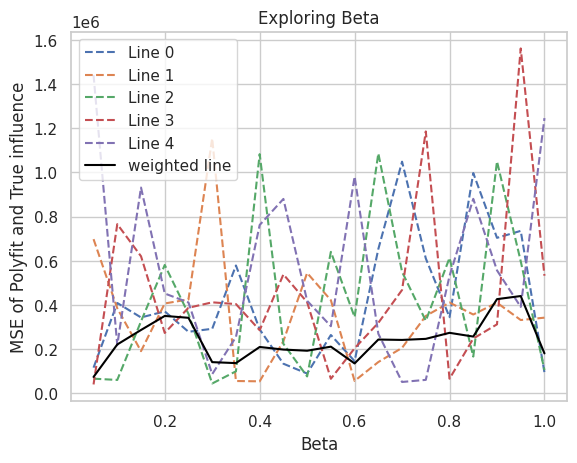

In [117]:
# Beta
plot_explorations([explore_betas(dataset=dataset_dropdown.value, delta_t=delta_t_slider.value, phi=phi_slider.value) \
                   for _ in range(5)], \
                  title="Exploring Beta", xaxis="Beta")

Running simulation for dataset infectious with delta_t 0.1 and phi 0.05 and beta 0.7
Total lines: 1729, train lines 1642
Starting at 12487 till 14129 to predict till 14216
Starting at [276 278 794] till [330 333 950] to predict till [330 332 965]
most influentual nodes: [(297, 98), (296, 89), (288, 74)]
Running simulation for dataset infectious with delta_t 0.1 and phi 0.1 and beta 0.7
Total lines: 1729, train lines 1556
Starting at 7605 till 9161 to predict till 9334
Starting at [157 170 530] till [190 228 593] to predict till [213 219 600]
most influentual nodes: [(218, 74), (215, 70), (219, 68)]
Running simulation for dataset infectious with delta_t 0.1 and phi 0.15000000000000002 and beta 0.7
Total lines: 1729, train lines 1469
Starting at 14785 till 16254 to predict till 16514
Starting at [ 348  358 1008] till [ 345  385 1140] to predict till [ 386  387 1182]
most influentual nodes: [(345, 116), (382, 89), (330, 79)]
Running simulation for dataset infectious with delta_t 0.1 and p

most influentual nodes: [(260, 72), (284, 71), (287, 71)]
Running simulation for dataset infectious with delta_t 0.1 and phi 0.45 and beta 0.7
Total lines: 1729, train lines 950
Starting at 28 till 978 to predict till 1757
Starting at [ 8 13 17] till [ 27  30 138] to predict till [ 29  30 209]
most influentual nodes: [(16, 124), (8, 116), (9, 108)]
Running simulation for dataset infectious with delta_t 0.1 and phi 0.5 and beta 0.7
Total lines: 1729, train lines 864
Starting at 9841 till 10705 to predict till 11570
Starting at [203 199 627] till [261 260 691] to predict till [288 291 751]
most influentual nodes: [(191, 88), (193, 86), (192, 83)]
Running simulation for dataset infectious with delta_t 0.1 and phi 0.55 and beta 0.7
Total lines: 1729, train lines 778
Starting at 14703 till 15481 to predict till 16432
Starting at [ 348  359 1001] till [ 333  332 1061] to predict till [ 372  373 1166]
most influentual nodes: [(345, 118), (330, 84), (331, 81)]
Running simulation for dataset in

most influentual nodes: [(191, 102), (193, 94), (192, 88)]
Running simulation for dataset infectious with delta_t 0.1 and phi 0.8500000000000001 and beta 0.7
Total lines: 1729, train lines 259
Starting at 717 till 976 to predict till 2446
Starting at [ 34  36 115] till [ 11  12 138] to predict till [ 71  73 249]
most influentual nodes: [(39, 92), (37, 90), (44, 78)]
Running simulation for dataset infectious with delta_t 0.1 and phi 0.9 and beta 0.7
Total lines: 1729, train lines 172
Starting at 7733 till 7905 to predict till 9462
Starting at [171 172 534] till [191 192 539] to predict till [210 230 606]
most influentual nodes: [(196, 68), (215, 67), (218, 66)]
Running simulation for dataset infectious with delta_t 0.1 and phi 0.9500000000000001 and beta 0.7
Total lines: 1729, train lines 86
Starting at 5317 till 5403 to predict till 7046
Starting at [151 165 415] till [139 142 420] to predict till [148 161 508]
most influentual nodes: [(142, 75), (181, 62), (160, 61)]
Running simulatio

most influentual nodes: [(219, 94), (200, 83), (196, 73)]
Running simulation for dataset infectious with delta_t 0.1 and phi 0.30000000000000004 and beta 0.7
Total lines: 1729, train lines 1210
Starting at 1582 till 2792 to predict till 3311
Starting at [ 59  60 192] till [ 40  84 273] to predict till [ 93 103 301]
most influentual nodes: [(71, 128), (70, 108), (73, 104)]
Running simulation for dataset infectious with delta_t 0.1 and phi 0.35000000000000003 and beta 0.7
Total lines: 1729, train lines 1123
Starting at 5415 till 6538 to predict till 7144
Starting at [ 84  85 420] till [177 174 476] to predict till [197 206 513]
most influentual nodes: [(113, 69), (112, 66), (142, 63)]
Running simulation for dataset infectious with delta_t 0.1 and phi 0.4 and beta 0.7
Total lines: 1729, train lines 1037
Starting at 5185 till 6222 to predict till 6914
Starting at [122 124 408] till [169 173 459] to predict till [112 113 500]
most influentual nodes: [(142, 63), (160, 62), (161, 59)]
Running

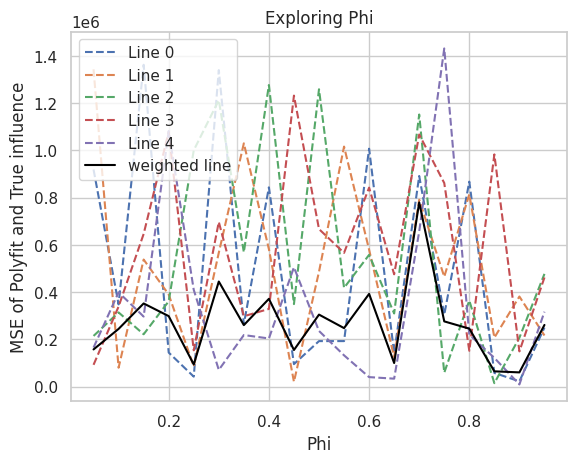

In [115]:
# Phi
plot_explorations([explore_phis(dataset=dataset_dropdown.value, delta_t=delta_t_slider.value, beta=beta_slider.value) \
                   for _ in range(5)], \
                 title="Exploring Phi", xaxis="Phi")

0.05
Running simulation for dataset infectious with delta_t 0.05 and phi 0.1 and beta 0.7
Total lines: 864, train lines 777
Starting at 7588 till 8365 to predict till 8452
Starting at [206 219 529] till [171 172 558] to predict till [177 182 562]
most influentual nodes: [(175, 43), (215, 41), (218, 41)]
0.1
Running simulation for dataset infectious with delta_t 0.1 and phi 0.1 and beta 0.7
Total lines: 1729, train lines 1556
Starting at 5565 till 7121 to predict till 7294
Starting at [113 115 429] till [154 161 512] to predict till [196 207 519]
most influentual nodes: [(181, 66), (113, 65), (142, 64)]
0.15000000000000002
Running simulation for dataset infectious with delta_t 0.15000000000000002 and phi 0.1 and beta 0.7
Total lines: 2594, train lines 2334
Starting at 7929 till 10263 to predict till 10523
Starting at [171 172 540] till [227 235 653] to predict till [192 194 669]
most influentual nodes: [(219, 114), (201, 106), (196, 99)]
0.2
Running simulation for dataset infectious wit

most influentual nodes: [(112, 147), (113, 141), (142, 116)]
0.35000000000000003
Running simulation for dataset infectious with delta_t 0.35000000000000003 and phi 0.1 and beta 0.7
Total lines: 6054, train lines 5448
Starting at 8956 till 14404 to predict till 15010
Starting at [196 199 585] till [355 365 980] to predict till [ 348  359 1027]
most influentual nodes: [(266, 164), (195, 159), (296, 141)]
0.4
Running simulation for dataset infectious with delta_t 0.4 and phi 0.1 and beta 0.7
Total lines: 6919, train lines 6227
Starting at 6297 till 12524 to predict till 13216
Starting at [169 182 463] till [281 288 796] to predict till [296 297 841]
most influentual nodes: [(195, 192), (192, 187), (193, 179)]
0.45
Running simulation for dataset infectious with delta_t 0.45 and phi 0.1 and beta 0.7
Total lines: 7784, train lines 7005
Starting at 3077 till 10082 to predict till 10861
Starting at [ 42  88 290] till [254 255 643] to predict till [268 269 710]
most influentual nodes: [(113, 15

most influentual nodes: [(195, 207), (193, 177), (192, 163)]
0.65
Running simulation for dataset infectious with delta_t 0.65 and phi 0.1 and beta 0.7
Total lines: 11243, train lines 10118
Starting at 5271 till 15389 to predict till 16514
Starting at [148 156 413] till [ 330  331 1054] to predict till [ 386  387 1182]
most influentual nodes: [(195, 201), (193, 181), (192, 180)]
0.7000000000000001
Running simulation for dataset infectious with delta_t 0.7000000000000001 and phi 0.1 and beta 0.7
Total lines: 12108, train lines 10897
Starting at 3098 till 13995 to predict till 15206
Starting at [ 66  67 291] till [315 316 907] to predict till [ 355  356 1040]
most influentual nodes: [(195, 210), (192, 192), (193, 178)]
0.75
Running simulation for dataset infectious with delta_t 0.75 and phi 0.1 and beta 0.7
Total lines: 12973, train lines 11675
Starting at 1786 till 13461 to predict till 14759
Starting at [ 66  67 210] till [290 296 858] to predict till [ 353  359 1006]
most influentual n

most influentual nodes: [(195, 204), (345, 184), (192, 182)]
0.9500000000000001
Running simulation for dataset infectious with delta_t 0.9500000000000001 and phi 0.1 and beta 0.7
Total lines: 16433, train lines 14789
Starting at 169 till 14958 to predict till 16602
Starting at [ 1  2 34] till [ 345  359 1022] to predict till [ 378  393 1210]
most influentual nodes: [(195, 218), (51, 196), (50, 176)]
0.05
Running simulation for dataset infectious with delta_t 0.05 and phi 0.1 and beta 0.7
Total lines: 864, train lines 777
Starting at 13341 till 14118 to predict till 14205
Starting at [264 266 851] till [228 230 948] to predict till [228 230 964]
most influentual nodes: [(266, 61), (297, 36), (230, 34)]
0.1
Running simulation for dataset infectious with delta_t 0.1 and phi 0.1 and beta 0.7
Total lines: 1729, train lines 1556
Starting at 12401 till 13957 to predict till 14130
Starting at [259 258 790] till [311 324 898] to predict till [330 333 950]
most influentual nodes: [(296, 98), (29

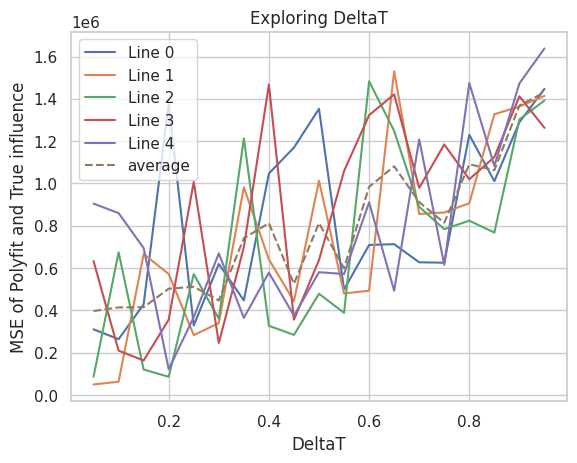

In [59]:
# DeltaT
plot_explorations([explore_deltat(dataset=dataset_dropdown.value, beta=beta_slider.value, phi=phi_slider.value) \
                   for _ in range(5)], \
                 title="Exploring DeltaT", xaxis="DeltaT")

In [116]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>